<a href="https://colab.research.google.com/github/yilmazgencc/recomender_system/blob/main/recommender_tf_nn_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
import os

In [21]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#tf.debugging.set_log_device_placement(True)

Num GPUs Available:  0


In [22]:
def dataset_prep(df):
    user_ids = df["userId"].unique().tolist()
    user2user_encoded = {x: i for i, x in enumerate(user_ids)}
    userencoded2user = {i: x for i, x in enumerate(user_ids)}
    movie_ids = df["movieId"].unique().tolist()
    movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
    movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
    df["user"] = df["userId"].map(user2user_encoded)
    df["movie"] = df["movieId"].map(movie2movie_encoded)

    num_users = len(user2user_encoded)
    num_movies = len(movie_encoded2movie)
    df["rating"] = df["rating"].values.astype(np.float32)
    # min and max ratings will be used to normalize the ratings later
    min_rating = min(df["rating"])
    max_rating = max(df["rating"])

    print(
        "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
            num_users, num_movies, min_rating, max_rating
        )
    )
    return num_users, num_movies, df ,min_rating, max_rating

In [23]:
movielens_zipped_file="/content/drive/MyDrive/ml-1m.zip"
movielens_dir=movielens_zipped_file[:-4]
if not os.path.isdir(movielens_dir):
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(Path(movielens_dir).parents[0])
        print("Done!")

pd.options.display.max_rows = 10
# unames = ['userId', 'gender', 'age', 'occupation', 'zip']
# users = pd.read_table(os.path.join(movielens_dir, "users.dat"), sep='::', header=None, names=unames, engine='python')
rnames = ['userId', 'movieId', 'rating', 'timestamp']
df = pd.read_table(os.path.join(movielens_dir, "ratings.dat"), sep='::', header=None, names=rnames, engine='python')
#ratings
# mnames = ['movieId', 'title', 'genres']
# movies = pd.read_table(os.path.join(movielens_dir, "movies.dat"), sep='::', header=None, names=mnames, engine='python')

num_users, num_movies, df, min_rating, max_rating=dataset_prep(df)

Number of users: 6040, Number of Movies: 3706, Min rating: 1.0, Max rating: 5.0


In [66]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train. Neglect normalization
y= df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
#y= df["rating"].apply(lambda x: x).values
# Assuming training on 80% of the data and validating on 10%.
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [46]:
EMBEDDING_SIZE = 100
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            #embeddings_initializer="he_normal",
            #embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        #print(tf.nn.sigmoid(x)*4 +1)
        return tf.nn.sigmoid(x)

In [67]:
EMBEDDING_SIZE = 100
class RecommenderNet_withNN(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, H1=50, D_out=1, **kwargs):
        super(RecommenderNet_withNN, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            #embeddings_initializer="he_normal",
            #embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            #embeddings_initializer="he_normal",
            #embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

        #linear layer adding

        self.linear1=layers.Dense(embedding_size*2, activation='relu')
        self.linear2=layers.Dense(H1,activation='relu' )
        self.linear3=layers.Dense(D_out,activation='softmax')

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])

        x=layers.Concatenate(axis=1)([user_vector, movie_vector])
        x_relu=self.linear1(x)
        h_relu=self.linear2(x_relu)
        output_scores=self.linear3(h_relu)

        #dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = output_scores + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        #tf.nn.sigmoid(x)
        return x


#model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model = RecommenderNet_withNN(num_users, num_movies, EMBEDDING_SIZE)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.0001) , metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError()]
)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "recommender_net_with_nn_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_56 (Embedding)    multiple                  604000    
                                                                 
 embedding_57 (Embedding)    multiple                  6040      
                                                                 
 embedding_58 (Embedding)    multiple                  370600    
                                                                 
 embedding_59 (Embedding)    multiple                  3706      
                                                                 
 dense_15 (Dense)            multiple                  40200     
                                                                 
 dense_16 (Dense)            multiple                  10050     
                                                                 
 dense_17 (Dense)            multiple    

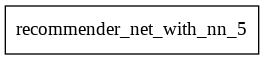

In [57]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

print(model.summary())
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/100
196/196 - 16s - loss: 1.5157 - accuracy: 0.2268 - root_mean_squared_error: 0.4086 - val_loss: 1.4839 - val_accuracy: 0.2240 - val_root_mean_squared_error: 0.4079 - 16s/epoch - 81ms/step
Epoch 2/100
196/196 - 9s - loss: 1.4447 - accuracy: 0.2268 - root_mean_squared_error: 0.4059 - val_loss: 1.4169 - val_accuracy: 0.2240 - val_root_mean_squared_error: 0.4052 - 9s/epoch - 48ms/step
Epoch 3/100
196/196 - 9s - loss: 1.3815 - accuracy: 0.2268 - root_mean_squared_error: 0.4033 - val_loss: 1.3565 - val_accuracy: 0.2240 - val_root_mean_squared_error: 0.4026 - 9s/epoch - 47ms/step
Epoch 4/100
196/196 - 9s - loss: 1.3249 - accuracy: 0.2268 - root_mean_squared_error: 0.4007 - val_loss: 1.3033 - val_accuracy: 0.2240 - val_root_mean_squared_error: 0.4001 - 9s/epoch - 47ms/step
Epoch 5/100
196/196 - 9s - loss: 1.2765 - accuracy: 0.2268 - root_mean_squared_error: 0.3982 - val_loss: 1.2578 - val_accuracy: 0.2240 - val_root_mean_squared_error: 0.3976 - 9s/epoch - 45ms/step
Epoch 6/100
196/19

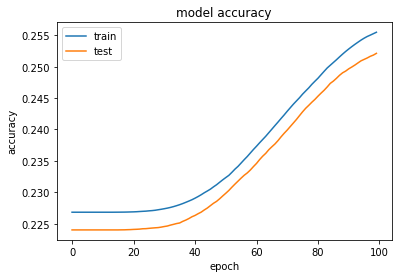

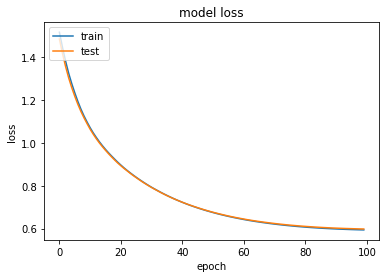

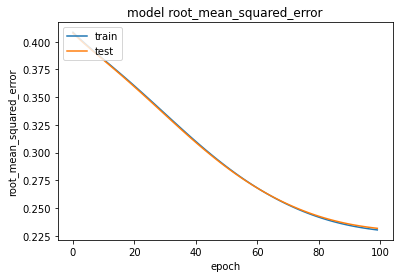

In [69]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=4096,
    epochs=100,
    verbose=2,
    validation_data=(x_val, y_val),
)
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()